In [135]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Optional, Tuple, Union
from sklearn.metrics import accuracy_score, confusion_matrix

The data used in this notebook is from kaggle. This is a synthetic Financial Datasets generated from the software called paysim1. The data is found to be cleaned which help me reduce the time to clean up and makes sense of the data given the limit time working on this project. The data set can be found following this link: https://www.kaggle.com/datasets/ealaxi/paysim1

In [136]:
path = "online_payment_fraud.csv"
fraud_df = pd.read_csv(path)

In [137]:
fraud_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [138]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [139]:
# calculate fraud percentage
total_fraud = sum(fraud_df["isFraud"])
percent_fraud = total_fraud/len(fraud_df["isFraud"])

print(percent_fraud*100)

0.12908204481801522


This is a very skewed data set wher the distribution of fraud is very tiny compared to normal trasaction. 

In [140]:
# check for missing value in each category
print(fraud_df.isna().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


-> the data was cleaned -> no Nan values -> no imputation required

In [141]:
indices = fraud_df.sample(n =10000).index

Below is the fraudrate by type running on the entire dataset Which confirm the representation of the above graph when sampling at a smaller number of data points. The fraud is mostly from the cash out and transfer trasactions. 

![Fraud rate by transaction type](output_fraudrate_types.png)

1
743


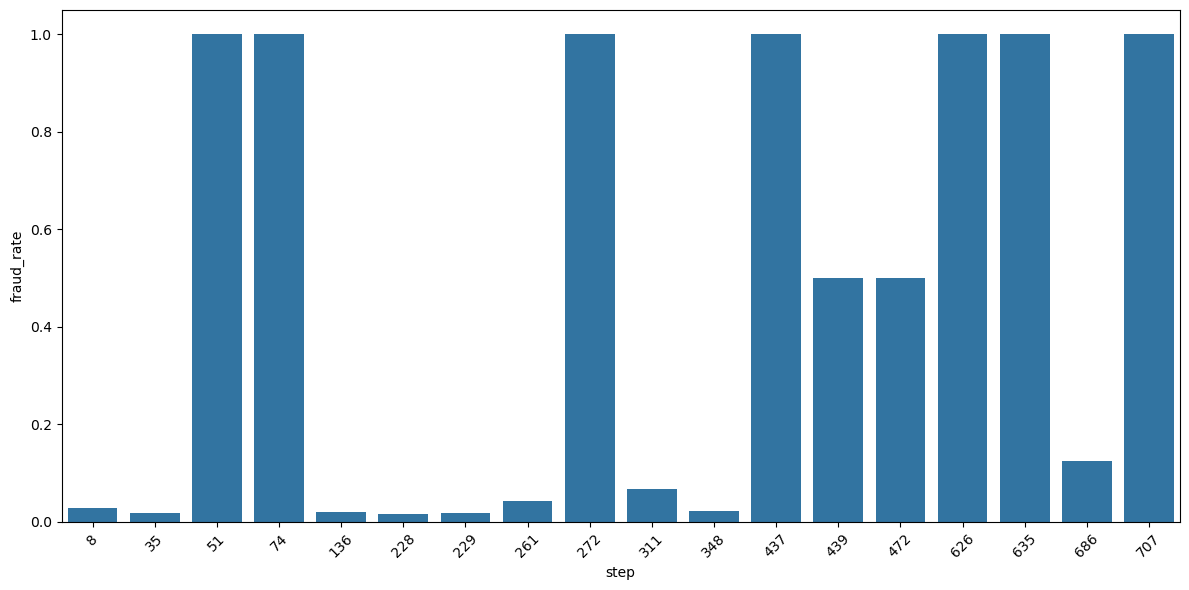

In [142]:
# analysing step data
# I'm trying to understand what exactly step are
# The description only state that "step: represents a unit of time where 1 step equals 1 hour"
print(min(fraud_df["step"]))
print(max(fraud_df["step"]))
sample_df = fraud_df.iloc[indices]
# compute fraud rate per step 
fraud_by_step = sample_df.groupby("step")["isFraud"].mean().reset_index(name="fraud_rate")
# ignore steps with zero fraud rate
fraud_by_step = fraud_by_step[fraud_by_step["fraud_rate"] > 0]
# sort by step and plot
fraud_by_step = fraud_by_step.sort_values("step")

plt.figure(figsize=(12, 6))
sns.barplot(data=fraud_by_step, x="step", y="fraud_rate")
plt.ylabel("fraud_rate")
plt.xlabel("step")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


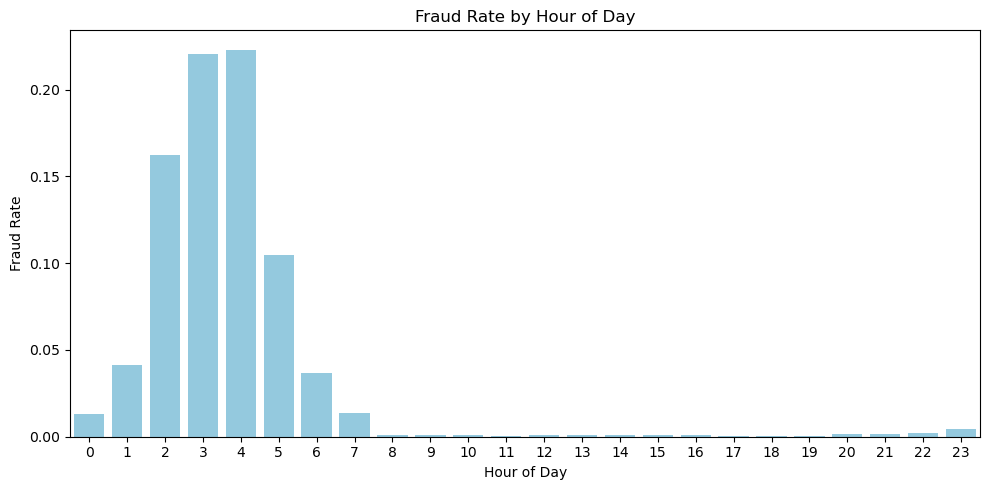

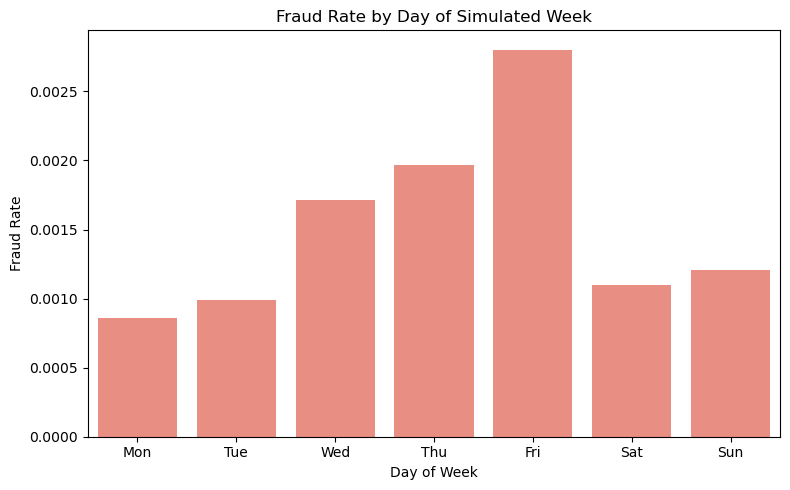

In [143]:
# assume the simulation start at 12 AM on a Monday
# create clear column names instead of concatenating unnamed Series (which produced duplicate 'step' columns)
extended_df = fraud_df.copy()

# Hour of the Day 
extended_df['hour_of_day'] = (extended_df['step'] - 1) % 24

# Day of the Week 
extended_df['day_of_week'] = ((extended_df['step'] - 1) // 24) % 7

# Fraud Rate by Hour of Day
fraud_by_hour = (
    extended_df
    .groupby("hour_of_day")["isFraud"]
    .mean()
    .reset_index(name="fraud_rate")
)
# Filter for hours that has fraud rate > than 0
fraud_by_hour = fraud_by_hour[fraud_by_hour["fraud_rate"] > 0]
fraud_by_hour = fraud_by_hour.sort_values("hour_of_day")

plt.figure(figsize=(10, 5))
sns.barplot(data=fraud_by_hour, x="hour_of_day", y="fraud_rate", color='skyblue')
plt.title('Fraud Rate by Hour of Day')
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Fraud rate by data of the week
fraud_by_day = (
    extended_df 
    .groupby("day_of_week")["isFraud"] 
    .mean()
    .reset_index(name="fraud_rate")
)
fraud_by_day = fraud_by_day[fraud_by_day["fraud_rate"] > 0]
fraud_by_day = fraud_by_day.sort_values("day_of_week")

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
fraud_by_day['day_label'] = fraud_by_day['day_of_week'].map(lambda x: day_names[x % 7])

plt.figure(figsize=(8, 5))
sns.barplot(data=fraud_by_day, x="day_label", y="fraud_rate", color='salmon')
plt.title('Fraud Rate by Day of Simulated Week')
plt.xlabel("Day of Week")
plt.ylabel("Fraud Rate")
plt.tight_layout()
plt.show()
                                   

As seen in figure above, the fraud mostly happened during quiete hours from midnight til 7AM. Cases also occurred in the middle of the week increasing toward Friday.  

Text(0.5, 1.0, 'Distribution of transfer error by Fraud Status')

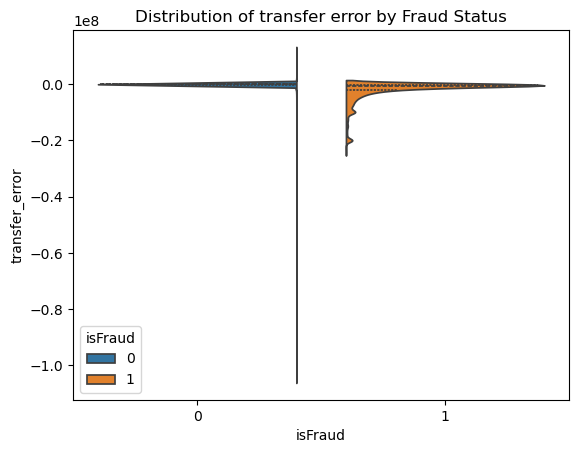

In [144]:
# goal: create  2 more columns that facilitate the comparision of the amount of money has been transfer as reflected on the sender account vs the recepient account. 
extended_df["sent_amount"] = fraud_df["newbalanceOrig"] - fraud_df["oldbalanceOrg"]
extended_df["received_amount"] = fraud_df["newbalanceDest"] - fraud_df["oldbalanceDest"]
extended_df["transfer_error"] = extended_df["sent_amount"] - extended_df["received_amount"]
extended_df["balance_error"] = extended_df["amount"] - extended_df["sent_amount"]

sns.violinplot(
    x= "isFraud",
    y = "transfer_error",
    data = extended_df,
    hue= "isFraud",
    split=True,
    inner= "quartitle",
)

plt.title("Distribution of transfer error by Fraud Status")


This is an insightful graph where we can see that the non fraud transaction balance are mostly peak at 0.0 for the error value which indicate that the balance are conserved in both account. The fraud data however, the error seems to spread out more toward the negative side indicated that the amount sent usually less than the actual receviceved amount which is very suspicious for these type of fraud.

<Figure size 1500x1500 with 0 Axes>

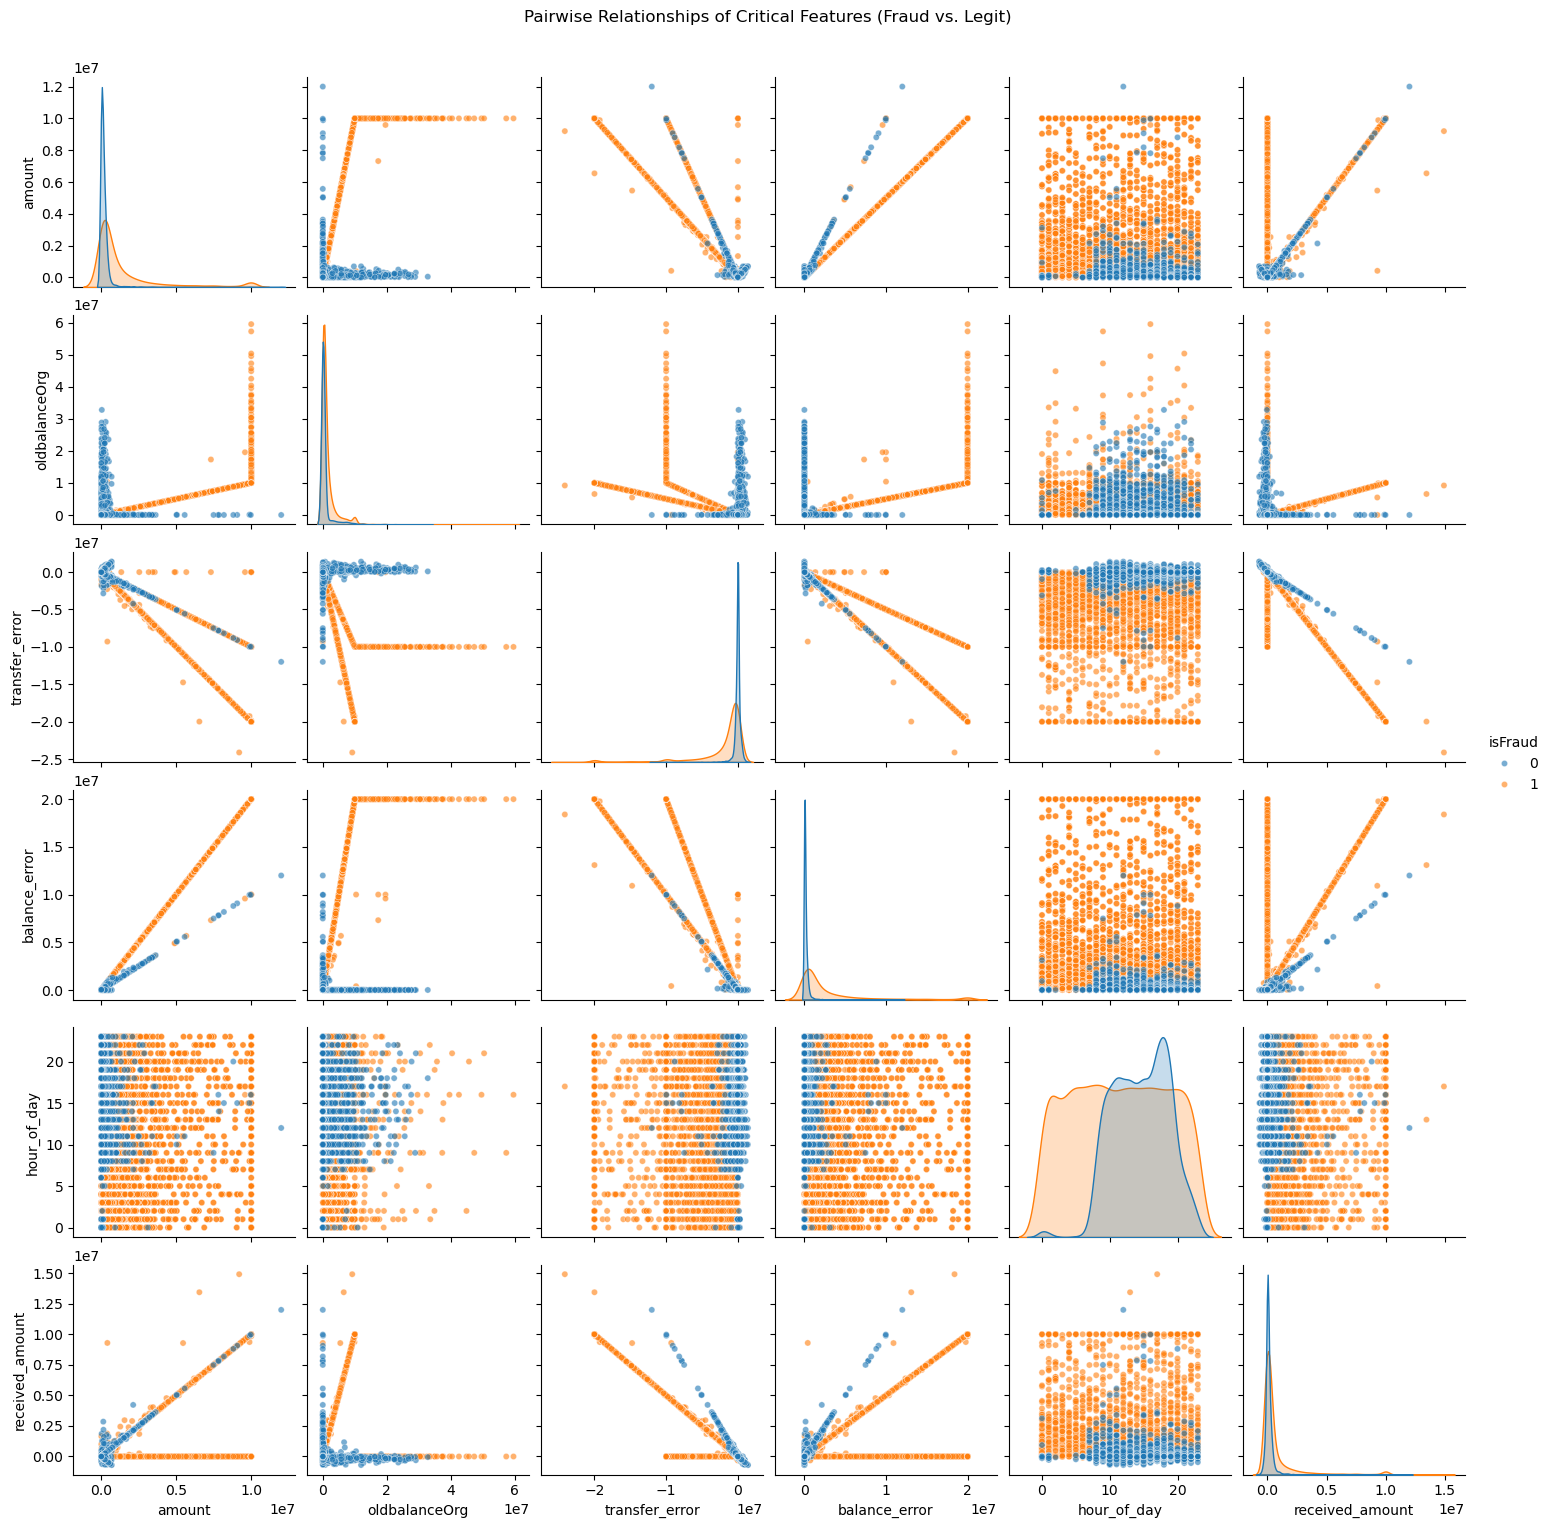

In [145]:
#Adjusted pairplot setup to reference only existing numeric features
critical_features = [
    'amount',
    'oldbalanceOrg',
    'transfer_error',
    'balance_error',
    'hour_of_day',
    'received_amount',
 ]
# Create a visualization sample that keeps all fraud cases while downsampling legit ones
fraud_cases = extended_df[extended_df['isFraud'] == 1]
legit_cases = extended_df[extended_df['isFraud'] == 0]
legit_sample = legit_cases.sample(n=5000, random_state=42)
viz_sample = pd.concat([fraud_cases, legit_sample], ignore_index=True)

plt.figure(figsize=(15, 15))
# Use only the selected features and color by fraud label
sns.pairplot(
    data=viz_sample,
    vars=critical_features,
    hue='isFraud',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 20}
 )
plt.suptitle('Pairwise Relationships of Critical Features (Fraud vs. Legit)', y=1.02)
plt.show()

Looking at the pairplot, the balance amounts before and after each transaction show strong correlations. Fraudulent cases cluster in their own regions when charted against certain features, reinforcing that this is a classification-friendly problem.

In [146]:
# compare the accuracy between the flagged transaction and the true fraud transaction
flagged_acc = accuracy_score(fraud_df.isFlaggedFraud, fraud_df.isFraud)
print(f"the accuracy score when the transaction is flagged: {flagged_acc} ")

the accuracy score when the transaction is flagged: 0.9987116942391656 


In [147]:
# part 2 use classification ml model to detect fraud.
# data Splitting
from sklearn.model_selection import train_test_split

def get_train_valid_test_data(X: pd.DataFrame, y: pd.Series):
    """Split feature matrix and target into train/validation/test sets."""
    X_trn, X_tst, y_trn, y_tst = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_trn, X_vld, y_trn, y_vld = train_test_split(
        X_trn, y_trn, test_size=0.25, random_state=42, stratify=y_trn
    )
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst


In [148]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def get_preprocessed_data() -> tuple[np.ndarray, pd.Series, np.ndarray, pd.Series, np.ndarray, pd.Series]:
    df = viz_sample.copy()
    df_processed = pd.get_dummies(df, columns=["type"], drop_first=False)
    y = df_processed["isFraud"].astype(int)
    X = df_processed.drop(columns=["isFraud"])
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        X = X.drop(columns=non_numeric_cols)

    scaled_features_candidates = [
        "step",
        "amount",
        "oldbalanceOrg",
        "newbalanceOrig",
        "oldbalanceDest",
        "newbalanceDest",
        "sent_amount",
        "received_amount",
        "transfer_error",
        "balance_error",
        "hour_of_day",
        "day_of_week",
    ]
    scaled_features = [col for col in scaled_features_candidates if col in X.columns]
    passthrough_features = [col for col in X.columns if col not in scaled_features]

    transformers = []
    if scaled_features:
        transformers.append((
            "numerical_scaling",
            StandardScaler(),
            scaled_features
        ))
    if passthrough_features:
        transformers.append((
            "categorical_passthrough",
            "passthrough",
            passthrough_features
        ))

    preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

    X_trn_raw, y_trn, X_vld_raw, y_vld, X_tst_raw, y_tst = get_train_valid_test_data(X, y)
    X_trn = preprocessor.fit_transform(X_trn_raw)
    X_vld = preprocessor.transform(X_vld_raw)
    X_tst = preprocessor.transform(X_tst_raw)
    
    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [149]:

def plot_confusion_matrix(
    y: Union[pd.Series, np.ndarray],
    y_hat: Union[pd.Series, np.ndarray],
    class_names: Optional[Dict[int, str]] = None,
    figsize: Tuple[int, int] = (10, 5),
    normalize: bool = False
 ) -> pd.DataFrame:
    y = np.asarray(y).ravel()
    y_hat = np.asarray(y_hat).ravel()
    labels = np.unique(np.concatenate([y, y_hat]))
    cfm = confusion_matrix(
        y_true=y,
        y_pred=y_hat,
        labels=labels,
        normalize="true" if normalize else None
    )
    if class_names is not None:
        tick_labels = [class_names.get(int(l), l) for l in labels]
    else:
        tick_labels = labels
    fig, ax = plt.subplots(figsize=figsize)
    cfm_df = pd.DataFrame(cfm, index=tick_labels, columns=tick_labels)
    sns.heatmap(
        cfm_df,
        annot=True,
        fmt=".2f" if normalize else "g",
        ax=ax
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Normalized Confusion Matrix" if normalize else "Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return cfm_df

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
# sample and balance out the data 
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()
Lg_rg = LogisticRegression(class_weight="balanced", max_iter=50, n_jobs=-1)
Lg_rg.fit(X_trn, y_trn)
y_hat_trn = Lg_rg.predict(X_trn)
y_hat_vld = Lg_rg.predict(X_vld)
y_hat_tst = Lg_rg.predict(X_tst)
acc_trn = accuracy_score(y_trn, y_hat_trn)
acc_vld = accuracy_score(y_vld, y_hat_vld)
acc_tst = accuracy_score(y_tst, y_hat_tst)


The tranning accuracy = 0.9018544215970733


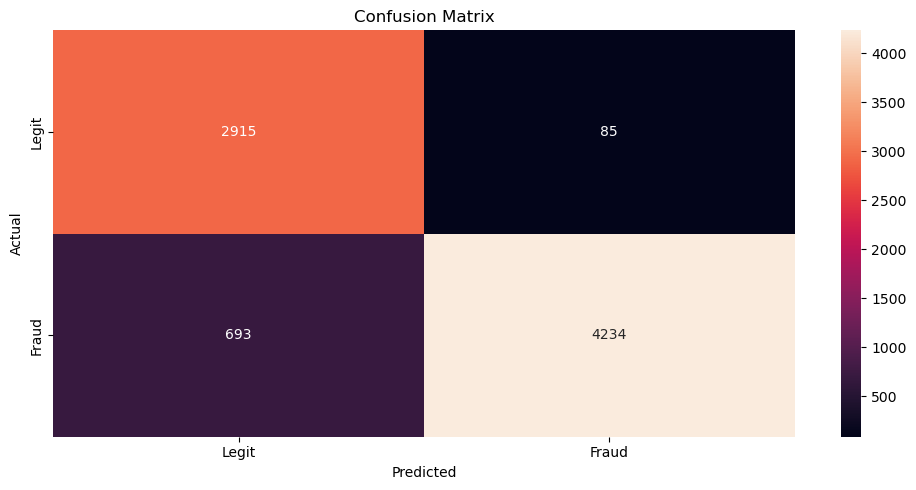

,Legit,Fraud
Legit,2915,85
Fraud,693,4234


In [151]:
# validating trn accuracy 
print(f"The tranning accuracy = {acc_trn}")
plot_confusion_matrix(y_trn, y_hat_trn, class_names={0: "Legit", 1: "Fraud"})

The validating accuracy = 0.8944381384790011


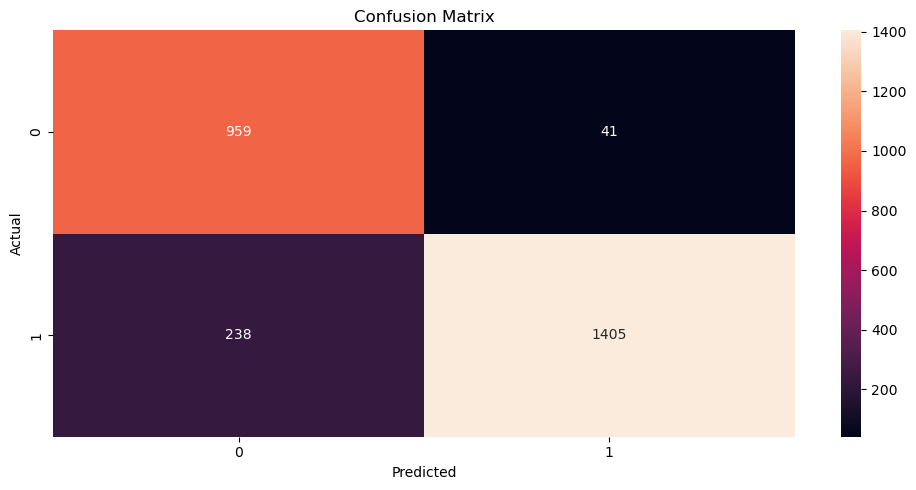

,0,1
0,959,41
1,238,1405


In [152]:
# validating accuracy
print(f"The validating accuracy = {acc_vld}")
plot_confusion_matrix(y_vld, y_hat_vld)

The testing accuracy = 0.9042754445705637


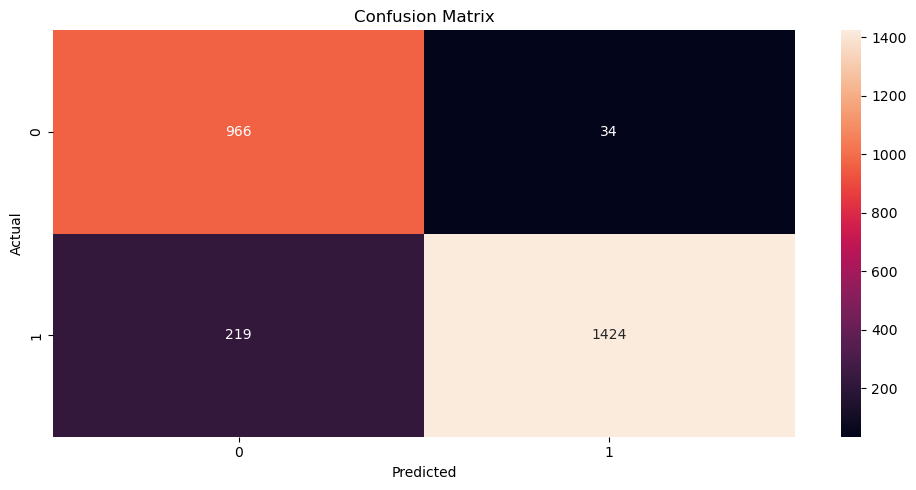

,0,1
0,966,34
1,219,1424


In [153]:
# test accuracy
print(f"The testing accuracy = {acc_tst}")
plot_confusion_matrix(y_tst, y_hat_tst)

In [154]:


def plot_decision_boundary(
    classifier: object,
    X: np.ndarray,
    y: np.ndarray,
    xlabel: str = "",
    ylabel: str = "",
    class_names: Optional[Dict[int, str]] = None,
    mesh_step: float = 0.02,
 ) -> None:
    """Visualize a 2-D decision surface for a binary classifier."""
    if X.shape[1] != 2:
        raise ValueError(f"Expected X to have 2 features, got {X.shape[1]}")

    if class_names is None:
        class_names = {}

    buffer = 0.5
    x_min, x_max = X[:, 0].min() - buffer, X[:, 0].max() + buffer
    y_min, y_max = X[:, 1].min() - buffer, X[:, 1].max() + buffer

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, mesh_step),
        np.arange(y_min, y_max, mesh_step),
    )

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    y_hat = classifier.predict(grid_points).reshape(xx.shape)

    plt.contourf(xx, yy, y_hat, alpha=0.3, cmap="coolwarm")
    for label in np.unique(y):
        class_mask = y == label
        class_name = class_names.get(int(label), f"class {int(label)}")
        plt.scatter(
            X[class_mask, 0],
            X[class_mask, 1],
            label=class_name,
            edgecolor="k",
            alpha=0.6,
        )

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

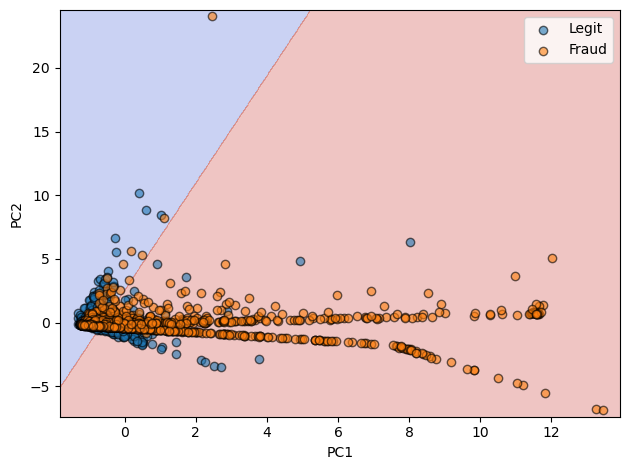

In [155]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

def _to_dense(matrix):
    return matrix.toarray() if hasattr(matrix, "toarray") else matrix

X_trn_dense = _to_dense(X_trn)
X_vld_dense = _to_dense(X_vld)

pca = PCA(n_components=2, random_state=42)
X_trn_2d = pca.fit_transform(X_trn_dense)
X_vld_2d = pca.transform(X_vld_dense)

viz_model = LogisticRegression(class_weight="balanced", max_iter=100)
viz_model.fit(X_trn_2d, y_trn)

plot_decision_boundary(
    viz_model,
    X_vld_2d,
    y_vld.values if hasattr(y_vld, "values") else y_vld,
    xlabel="PC1",
    ylabel="PC2",
    class_names={0: "Legit", 1: "Fraud"}
)

In [156]:
# random forest tree model
from sklearn.ensemble import RandomForestClassifier
rd_forest = RandomForestClassifier(n_estimators=10, max_depth=5)
rd_forest.fit(X_trn, y_trn)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [157]:
y_hat_trn = rd_forest.predict(X_trn)
y_hat_vld = rd_forest.predict(X_vld)
y_hat_tst = rd_forest.predict(X_tst)
rf_acc_trn = accuracy_score(y_trn, y_hat_trn)
rf_acc_vld = accuracy_score(y_vld, y_hat_vld)
rf_acc_tst = accuracy_score(y_tst, y_hat_tst)

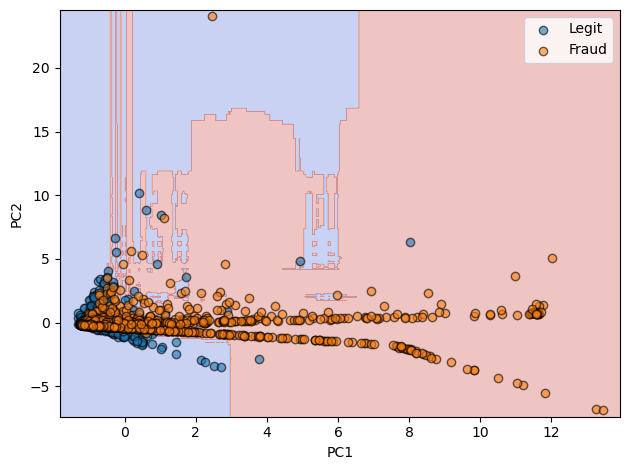

In [158]:
pca_rf = PCA(n_components=2, random_state=42)
X_trn_rf_2d = pca_rf.fit_transform(_to_dense(X_trn))
X_vld_rf_2d = pca_rf.transform(_to_dense(X_vld))
rf_viz_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
 )
rf_viz_model.fit(X_trn_rf_2d, y_trn)
plot_decision_boundary(
    rf_viz_model,
    X_vld_rf_2d,
    y_vld.values if hasattr(y_vld, "values") else y_vld,
    xlabel="PC1",
    ylabel="PC2",
    class_names={0: "Legit", 1: "Fraud"}
 )

Random forest training accuracy = 0.9678


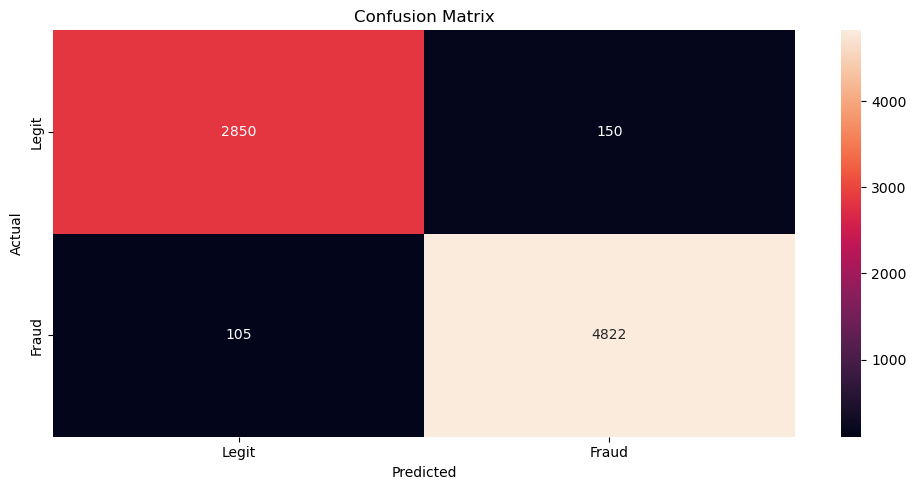

,Legit,Fraud
Legit,2850,150
Fraud,105,4822


In [159]:
print(f"Random forest training accuracy = {rf_acc_trn:.4f}")
plot_confusion_matrix(
    y_trn,
    y_hat_trn,
    class_names={0: "Legit", 1: "Fraud"}
 )

Random forest validation accuracy = 0.9535


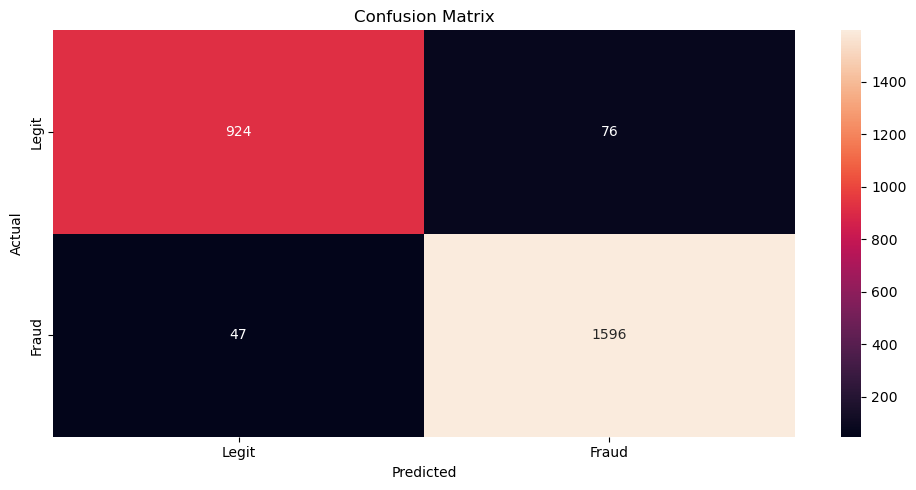

,Legit,Fraud
Legit,924,76
Fraud,47,1596


In [162]:
print(f"Random forest validation accuracy = {rf_acc_vld:.4f}")
plot_confusion_matrix(
    y_vld,
    y_hat_vld,
    class_names={0: "Legit", 1: "Fraud"}
 )

Random forest test accuracy = 0.9637


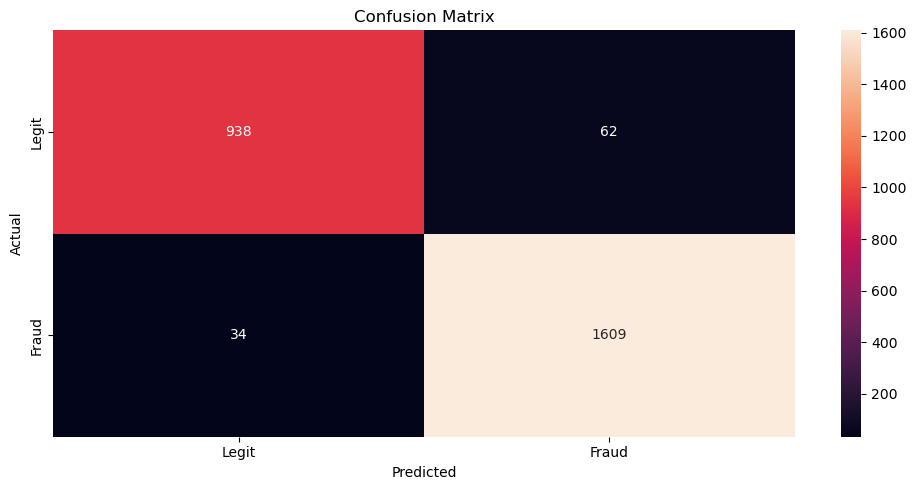

,Legit,Fraud
Legit,938,62
Fraud,34,1609


In [161]:
print(f"Random forest test accuracy = {rf_acc_tst:.4f}")
plot_confusion_matrix(
    y_tst,
    y_hat_tst,
    class_names={0: "Legit", 1: "Fraud"}
 )